Assignment 1 : Image Recognition - Happy Face Detection <br>
Name : Summan Bahadur

In [1]:
#Import all packages
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
#Function to load dataset
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
#Call the load function
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
#There are two classes 0-Not Happy and 1-Happy
print(classes)

[0 1]


Training Image: 
Associated Output : [1]


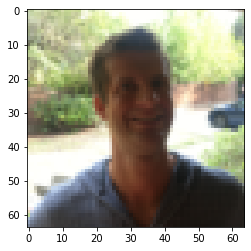

In [5]:
#Example of an image
index=1
print('Training Image: ')
plt.imshow(train_set_x_orig[index])
print('Associated Output : '+ str(train_set_y[:,index]) )

In [6]:
#Shape of training example
#Shape of training example is (m_train , num_px , num_px , 3) , where m_train is the number of training examples
#num_px is the width = height of the training image
train_set_x_orig.shape

(600, 64, 64, 3)

In [7]:
test_set_x_orig.shape

(150, 64, 64, 3)

In [8]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print('m_train = '+str(m_train) +' m_test= '+str(m_test) + 'num_')

m_train = 600 m_test= 150num_


Preprocessing

In [9]:
#Reshaping each example of size(num_px , num_px , 3)  to -> (num_px*num_px*3,1)
#A trick to flattern an image of shape (a,b,c,d) to a matrix X_flattern of shape (b*c*d , a)
#X_flattern = X.reshape(X.shape[0],-1).T

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

In [10]:
train_set_x_flatten.shape

(12288, 600)

In [11]:
#Standarize our dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

Creating Model

In [12]:
#1- Initialize the parameters
#2- Learn the parameters by minimizing the cost
#3- Use the learnt parameters to make the predictions


In [13]:
#Helper Function - Sigmoid Function

def sigmoid(z):
    #z is a scalar or a numpy array of any size
    s = 1/ (1+np.exp(-z))
    return s

In [14]:
print(sigmoid(np.array([0,2])))

[0.5        0.88079708]


In [15]:
#Initialize function
#This function creates a vector of size (dim,1) for w and sets b to 0
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim,1), dtype=np.float32)
    b=0
    return w,b
    

In [16]:
#Forward and backward propagation
#Propagate function that calculates the cost function and its gradient

# Input
# w - weights, a numpy array of size (num_px*num_px*3,1)
# b - bias , a scalar
# X - data of size (num_px*num_px*3 , num_of_examples)
# Y - true label vector (containing 0 or 1) of size (1, num_of_examples)

# Output
# cost - negative log - likelihood cost of logistic regression
# dw - gradient of the loss with respect to w - same shape as w
# db - gradient of the loss with respect to b - same shape as b

def propagate(w,b,X,Y):
    m = X.shape[1]
    #Forward propagation from X to Cost
    A = sigmoid(np.dot(w.T,X) +b)
    cost = (-1./m)*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)), axis=1)
    
    #Backward propagation
    dw = (1./m) * np.dot(X , ((A-Y).T))
    db = (1./m) * np.sum(A-Y , axis=1)
    
    
    assert (dw.shape == w.shape)
    assert (db.dtype == float)
    
    cost = np.squeeze(cost)
    
    
    grades = {'dw' :dw ,'db' : db}
    
    return grades , cost

Optimization

In [17]:
#We have initialized out paramters
#We are also able to find cost function and it's gradient
#Now , we want to update the parameters using gradient descent

In [18]:
# The goal is to learn w and b by minimizing J . 
#For a parameter 0 the update rule is 0 = 0 -a d0 where a is the learning rate

def optimize(w,b,X , Y ,num_iterations , learning_rate , print_cost = False):
    # We need to do following two steps
    # 1 - Calculate cost and gradient of the current paramaters using propagate
    # 2 - Update the parameters using gradient descent rule for w and b
    
    costs = []
    
    for i in range(num_iterations):
        
        grads , cost = propagate(w=w, b=b , X=X , Y=Y)
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate * db
        
        #Record the costs
        if i % 100 ==0:
            costs.append(cost)
            
        #Print the cost every one hundered iterations
        if print_cost and (i%100==0):
            print('Cost after iteration %i : %f' %(i,cost))

            
    params = {'w':w , 'b':b}
    grads = {'dw':dw , 'db':db}
        
    return params , grads , costs
        
    

In [19]:
#Prediction

#Two steps for prediction
# 1 - Calculate Y^ = A = sigmoid (w.T * X) +b
# 2 - Convert the entries of A into 0 (if activation <=0.5) or 1 (if activation >0.5) 

def predict(w , b , X):
    m = X.shape[1]
    
    Y_prediction = np.zeros(shape=(1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0,i] >=0.5:
            Y_prediction[0,i] =1
        else:
            Y_prediction[0,i] =0
        

    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [20]:
#Model - Merge all functions into a model

def model(X_train , Y_train , X_test , Y_test , num_iterations=2000 , learning_rate=0.5 , print_cost= False):
    
    #Initialize
    w , b = initialize_with_zeros (X_train.shape[0])
    
    #Gradient Descent
    parameters , grads , costs = optimize (w , b , X_train , Y_train , num_iterations , learning_rate , print_cost)
    
    w= parameters['w']
    b = parameters ['b']
    
    #Predict test and training set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    
      # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    
    

In [21]:
#Run the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0 : 0.693147
Cost after iteration 100 : 1.458491
Cost after iteration 200 : 0.682289
Cost after iteration 300 : 0.426329
Cost after iteration 400 : 0.210642
Cost after iteration 500 : 0.180986
Cost after iteration 600 : 0.168836
Cost after iteration 700 : 0.159491
Cost after iteration 800 : 0.151692
Cost after iteration 900 : 0.144944
Cost after iteration 1000 : 0.138995
Cost after iteration 1100 : 0.133689
Cost after iteration 1200 : 0.128914
Cost after iteration 1300 : 0.124588
Cost after iteration 1400 : 0.120646
Cost after iteration 1500 : 0.117033
Cost after iteration 1600 : 0.113709
Cost after iteration 1700 : 0.110636
Cost after iteration 1800 : 0.107785
Cost after iteration 1900 : 0.105131
train accuracy: 98.16666666666667 %
test accuracy: 95.33333333333333 %


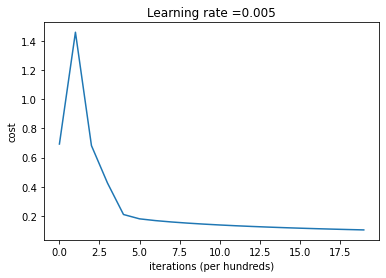

In [23]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Test with our own image

In [30]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
#my_image = "happy_face.jpg"  

my_image = "sad_face2.jpg"  

fname = "images/" + my_image
x = np.array(plt.imread(fname))

In [31]:
from PIL import Image
import numpy as np 

img = Image.fromarray(x)
img = img.resize((num_px,num_px))
x = np.asarray(img)
x = x.reshape(1, num_px*num_px*3)
x = x.T

y = 0.0, your algorithm predicts a "Not Happy Face" picture.


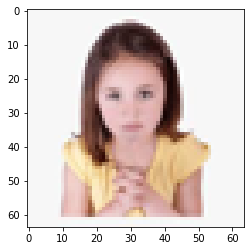

In [32]:
my_predicted_image = predict(d["w"], d["b"], x)

plt.imshow(img)

y = np.squeeze(my_predicted_image)

output = 'Happy Face'
if(y ==0):
    output = 'Not Happy Face'
    
print("y = " + str(y) + ", your algorithm predicts a \"" +output +   "\" picture.")